In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import matplotlib.pyplot as plt
from time import time
import sys
from abel.direct import direct_transform
from abel.tools.analytical import GaussianAnalytical
from xbeamfit import fitting
from xbeamfit import distributions 
import json
import numpy as np
import scipy as sp
import pandas as pd
import sys
import xbeamfit as xb 
from scipy import interpolate
from numpy import trapz
import scipy.integrate as integrate
from scipy import special
from scipy.stats import norm

from scipy.stats import chi
from scipy.stats import chi2

Let us consider the normalized phase space $x-p_x$ and a 2D matched density distribution $\rho$.

For the linear case, a matched distribution is rotation invariant, that is, in the $J_x,\mu$ variables, we can write $\rho(r=\sqrt{2 J_x},\phi)=\rho(r)$. 

Here we use the $r$-notation instead of the $J$-notation to stay compatible with the Abel transform's standard form.
We consider for $\rho$ the following normalization:
$$
\int_0^\infty  \int_0^{2\pi} \rho( r ) \ r\ dr\ d\phi = 2\pi \int_0^\infty  \rho( r ) \ r\ dr =1.
$$

By defining a linear radial density $\rho_r(r)=2\pi \rho(r) \ r$, we have

$$
\int_0^\infty \rho_r( r ) dr= 1
$$


We would like to have a way of going between the distribution in $x$, the line density $\rho_r(r)$, and the distribution in terms of the action, $\rho(J_x) $ for an arbitrary beam profile in $x$. 


## Problem: 

Given a physical space distribution of a particle beam in x, can we find the percentage of the particles which are removed from the beam when a collimator is at $x$ = 4.5 $\sigma$, meaning a matched cut of $J_x$ = 4.5 $\sigma$?

$r = \sqrt{x^2 + x'^2}$

$J_x = r^2/2$ the action. 


We want to go from the normalised phase space in $x, x'$ of the Hamiltonian density, to the beam profile distribution in physical/ normal space.

We can work in reverse, going from a beam profile distribution in $x$, assuming the distribution is symmetric and normalising it. 

## 1. Normalise the distribution using the machine parameters at the measurement point 

To go from physical to normalised coordinates we apply the matrix in 2D normalisation to matrix in $x$ and $x'$



\begin{bmatrix}
    1/\sqrt\beta & 0 \\
    \alpha/\sqrt\beta & \sqrt\beta
  \end{bmatrix}




## 2. Given the normalised p.d.f distribution in $x$, which is symmetric about 0, transform using the Abel transform to get PDF$(r)$

For a non-Gaussian distribution in $x(\sigma)$, we want to find the PDF($J_x$). $


We can use the inverse Abel transform to go from the $x(\sigma)$ to PDF$(r)$, removing the dependence on $\phi$ because it is circularly symmetric. 



The inverse Abel transform is defined as: 
$$
f(r)=-{\frac {1}{\pi }}\int _{r}^{\infty }{\frac {dF}{dy}}\,{\frac {dy}{\sqrt {y^{2}-r^{2}}}}
$$

Where $F(x,y)$ is a circularly symmetric function, for example a beam profile which is symmetric about $x=0$. 





The inverse Abel transform projects the 1D distribution in $x$, to a distribution in $r=\sqrt{x^2 + x'^2}$ requiring that the distribution is normalised, meaning the phase space ellipse is circular. We can use this to find a line density of particles along r, by multiplying by $2\pi r$ . 


$$
PDF(r)= 2 \pi r  \mathcal{A}^{-1} [PDF(x)] 
$$

Where $\mathcal{A}^{-1}$ is the inverse Abel transform. 


## 3. Given a distribution $PDF(r)$, can we find the $PDF(J_x)$ where $J_x = r^2/2$

From probability theory:

If $F_X(x)$  is a PDF of a random variable $X$, 


and $Y= g(X)$, and 
- $g(x)$ is differentiable
- $g(x)$ is a strictly increasing function: $x_1 < x_2 $ then $g(x_1) < g(x_2)$

Then:

$$
F_Y(y) = F_X(x_1)/g'(x_1) 
$$

Where $g(x_1) = y$

https://www.probabilitycourse.com/chapter4/4_1_3_functions_continuous_var.php


Translating our problem from going from $r$ to Action $J_x$:


Then we can find the PDF of $J_x = r^2/2$ from the PDF of $r$, 


$$
g(r) = r^2/2, g'(r) = r 
$$


$$
PDF(J_x) = PDF(r)/r
$$

### Example: For a Gaussian beam distribution 

Falling back to a pure Python backend...


Text(0, 0.5, 'p.d.f')

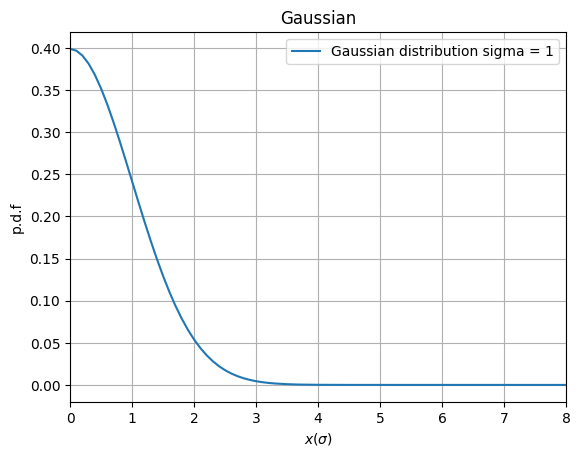

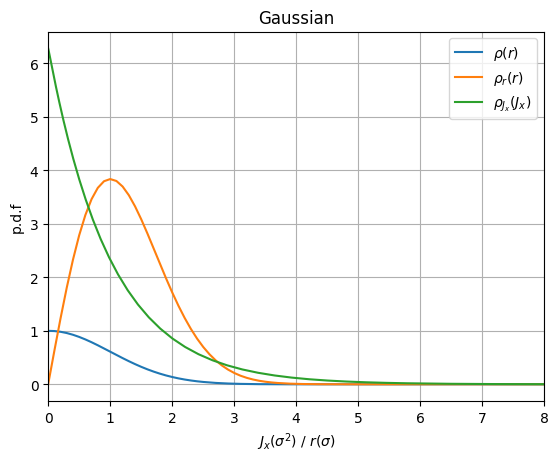

In [23]:
############ normalised beam distribution symmetric about 0 
x = np.linspace(0.00001,100,1000)

gauss = xb.distributions.Gaussian(x,mu=0,sig=1,A=1)

plt.figure()
plt.plot(x,gauss, label='Gaussian distribution sigma = 1')
plt.legend()
plt.xlim([0,8])
plt.grid()
plt.title('Gaussian')
plt.xlabel('$x(\sigma)$')
plt.ylabel('p.d.f')


############ Inverse Abel transform of only the POSITIVE DEFINED part of the distribution 

r = np.linspace(0.00001,100,1000)
abel_gauss = direct_transform(gauss, dr=np.diff(x)[0], direction="Inverse", correction=True)




rho_r_r_gauss = r*abel_gauss*2*np.pi



########### Find the pdf in Jx 

pdf_jx_gauss = rho_r_r_gauss/r
jx = r**2/2


plt.figure()
plt.plot(r, abel_gauss,label='$\\rho(r)$')
plt.legend()
plt.plot(r,rho_r_r_gauss, label='$\\rho_r(r)$')
plt.plot(jx,pdf_jx_gauss, label='$\\rho_{J_x}(J_x)$')
plt.legend()
plt.xlim([0,8])
plt.grid()
plt.title('Gaussian')
plt.xlabel('$J_x(\sigma^2$) / $r(\sigma)$')
plt.ylabel('p.d.f')



4.5 sigma cut takes  0.9675287543139888 %


Text(0, 0.5, 'p.d.f')

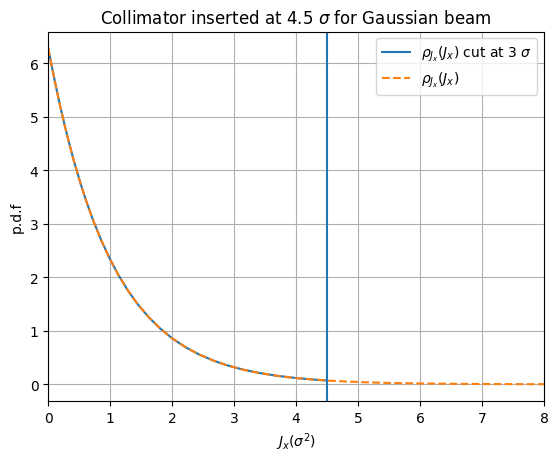

In [4]:
########## define a collimator position in J_x

collim_position = 4.5


######### interpolate the pdf of J_x to find the curve up to the desired collimator position 

xcollim = np.linspace(0.0000,collim_position,200) # 0 to 3 sigma
x = jx
y = pdf_jx_gauss
ycollim = np.interp(xcollim, x, y)


########### integrate the interpolated function and the pdf of J_x 

perc_cut = sp.integrate.simps(ycollim, x=xcollim, dx=1, axis=-1,)
perc_all = sp.integrate.simps(pdf_jx_gauss, x=jx, dx=1, axis=-1,)

########### calculate percentage lost 

perc_g = 100-(perc_cut/perc_all*100)
print(str(collim_position) , 'sigma cut takes ',  perc_g, '%')


########### plot 

plt.figure()
plt.plot(xcollim, ycollim, label='$\\rho_{J_x}(J_x)$ cut at 3 $\sigma$ ')
plt.plot(jx,pdf_jx_gauss, linestyle= '--',label='$\\rho_{J_x}(J_x)$',)
plt.legend()
plt.grid()
plt.title('Collimator inserted at ' + str(collim_position) + ' $\sigma$ for Gaussian beam')
plt.xlabel('$J_x(\\sigma^2)$')
plt.axvline(x=collim_position)
plt.xlim([0,8])
plt.ylabel('p.d.f')




### Example: For a q-Gaussian distribution 

Falling back to a pure Python backend...


Text(0, 0.5, 'p.d.f')

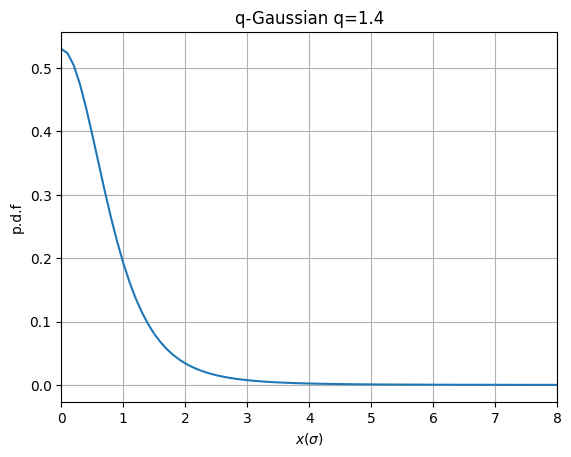

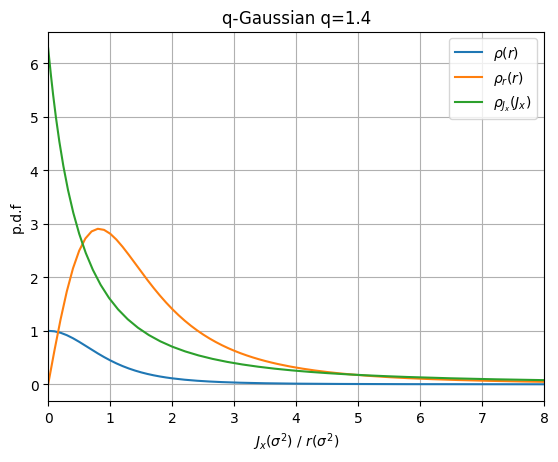

In [16]:
############ beam distribution symmetric about 0 
x = np.linspace(0.00001,100,1000)

q0=1.4
b0=1/(5-3*q0)



qgauss = xb.distributions.qGauss(x,mu=0,q=q0,A=1,b=b0)
qgauss = np.nan_to_num(qgauss, 0)

plt.plot(x,qgauss)
plt.xlim([0,8])
plt.grid()
plt.title('q-Gaussian q=' + str(q0))
plt.xlabel('$x(\sigma)$')
plt.ylabel('p.d.f')


############ Inverse Abel transform 

r = np.linspace(0.00001,100,1000)
abel_qgauss = direct_transform(qgauss, dr=np.diff(x)[0], direction="Inverse", correction=True)




rho_r_r_q = r*abel_qgauss*2*np.pi



########### Find the pdf in Jx 

pdf_jx_q = rho_r_r_q/r
jx = r**2/2


plt.figure()
plt.plot(r, abel_qgauss,label='$\\rho(r)$')
plt.legend()
plt.plot(r,rho_r_r_q, label='$\\rho_r(r)$')
plt.plot(jx,pdf_jx_q, label='$\\rho_{J_x}(J_x)$')
plt.legend()
plt.xlim([0,8])
plt.grid()
plt.title('q-Gaussian q=' + str(q0))
plt.xlabel('$J_x(\sigma^2$) / $r(\sigma)$')
plt.ylabel('p.d.f')





### Evaluate the lost particles with a collimator at $J_x = 4.5$

If we cute at 6 sigma, we integrate between 6 and infinite sigma to know the intensity in the beam in the Amplitude space 
for a Gaussian beam 





4.5 sigma cut takes  17.98755135457749 %


Text(0, 0.5, 'p.d.f')

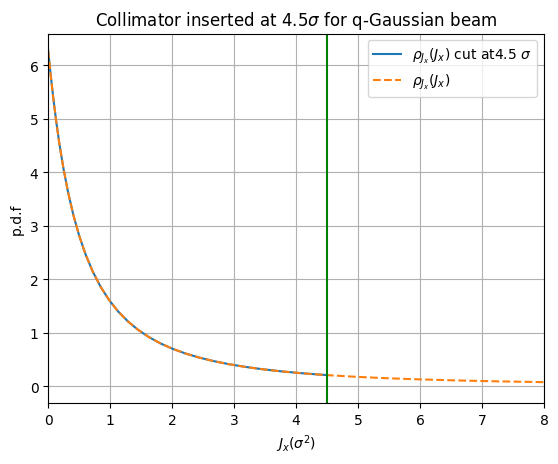

In [19]:
############ define your collimator position 

collim_position = 4.5

############ Interpolate the pdf 

xcollim = np.linspace(0.0000,collim_position,200) # 0 to 3 sigma
x = jx
y = pdf_jx_q
ycollim = np.interp(xcollim, x, y)


############# Integrate up to the collimator and then normalise

perc_cut = sp.integrate.simps(ycollim, x=xcollim, dx=1, axis=-1,)
perc_all = sp.integrate.simps(pdf_jx_q, x=jx, dx=1, axis=-1,)


############## calculate percentage lost 

perc_q = 100-(perc_cut/perc_all)*100
print(str(collim_position) , 'sigma cut takes ',  perc_q, '%')


############### plot
plt.figure()
plt.plot(xcollim, ycollim, label='$\\rho_{J_x}(J_x)$ cut at' + str(collim_position) +  ' $\sigma$ ')
plt.plot(jx,pdf_jx_q, linestyle= '--',label='$\\rho_{J_x}(J_x)$',)
plt.legend()
plt.grid()
plt.title('Collimator inserted at ' + str(collim_position) + '$\sigma$ for q-Gaussian beam')
plt.xlabel('$J_x(\\sigma^2)$')
plt.axvline(x=collim_position, color='g')
plt.xlim([0,8])
plt.ylabel('p.d.f')




### Comparison for two different beam distributions

Gaussian, q-Gaussian:  0.9675287543139888 % 17.98755135457749 %


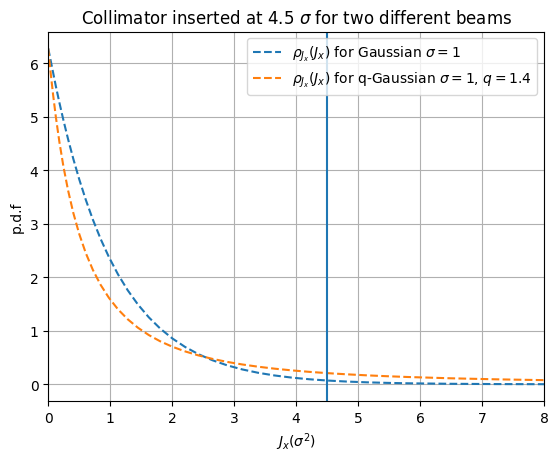

In [14]:
plt.plot(jx,pdf_jx_gauss, linestyle= '--',label='$\\rho_{J_x}(J_x)$ for Gaussian $\sigma=1$',)


plt.plot(jx,pdf_jx_q, linestyle= '--',label='$\\rho_{J_x}(J_x)$ for q-Gaussian $\sigma=1$, $q=$' + str(q0),)
plt.legend()
plt.grid()
plt.title('Collimator inserted at 4.5 $\sigma$ for two different beams')
plt.xlabel('$J_x(\\sigma^2)$')
plt.axvline(x=collim_position)
plt.xlim([0,8])
plt.ylabel('p.d.f')

print('Gaussian, q-Gaussian: ', perc_g,'%', perc_q, '%')
